In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

# Getting the data

In [3]:
file_path = '/kaggle/input/playground-series-s4e9/train.csv'
df = pd.read_csv(file_path)

df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
df.shape

(188533, 13)

# 1. Exploratory Data Analysis

## 1.1 Relationship between model_year and price

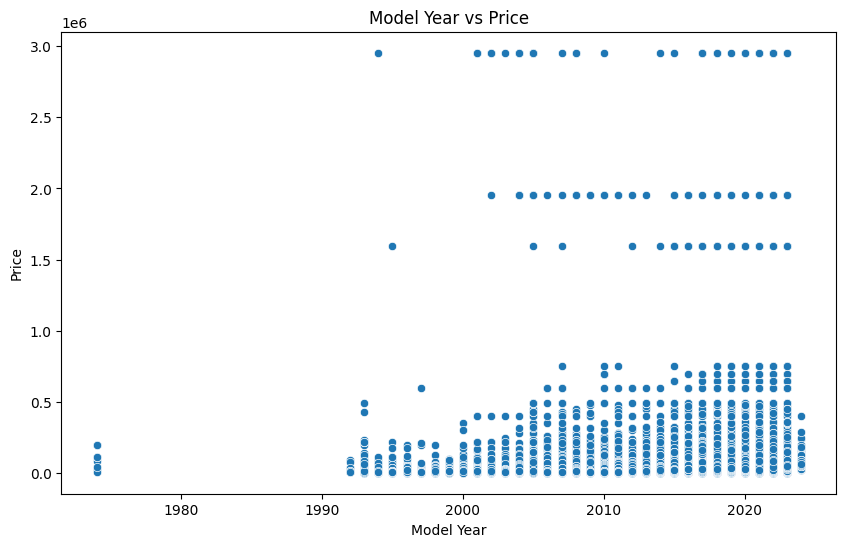

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='model_year', y='price', data=df)
plt.title('Model Year vs Price')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()




## 1.2 Relationship between milage and price

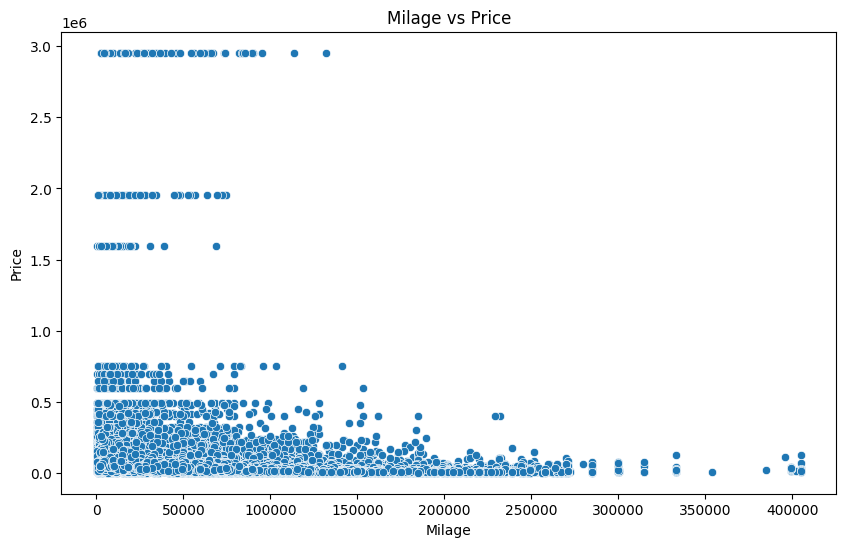

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='milage', y='price', data=df)
plt.title('Milage vs Price')
plt.xlabel('Milage')
plt.ylabel('Price')
plt.show()

## 1.3 Heatmap to check relationship among numerical features

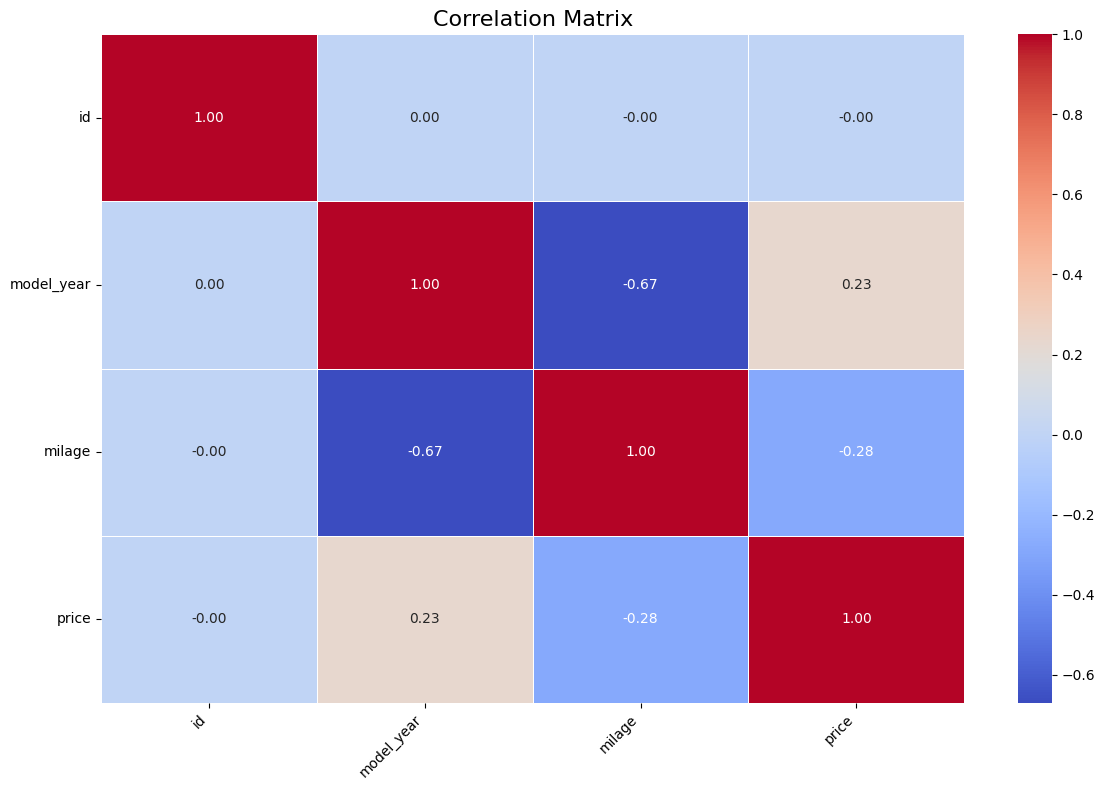

In [7]:
num_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
corr_matrix = num_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

There is a correlation of -0.67 between milage and model_year indicates a moderately strong negative relationship. So we can say that as the model year increases (i.e., cars are newer), the mileage tends to decrease. This is an expected relationship, as newer cars generally have lower mileage, and older cars typically have higher mileage due to extended use.

## 1.4 Count Plot by brand

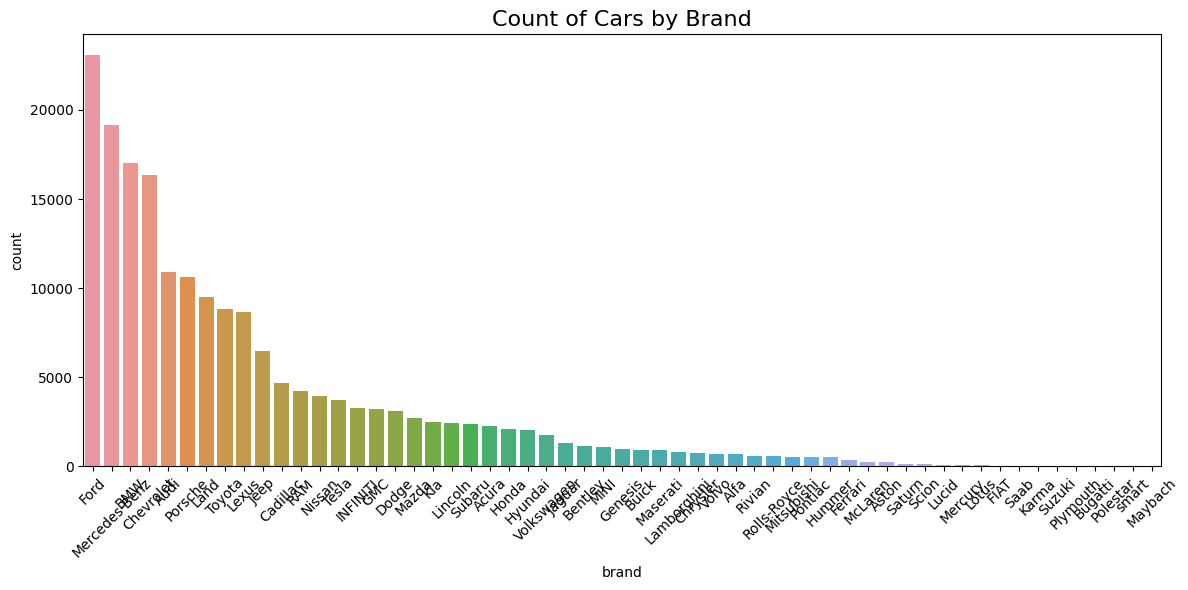

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='brand', order=df['brand'].value_counts().index)
plt.title('Count of Cars by Brand', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.5 Box Plot

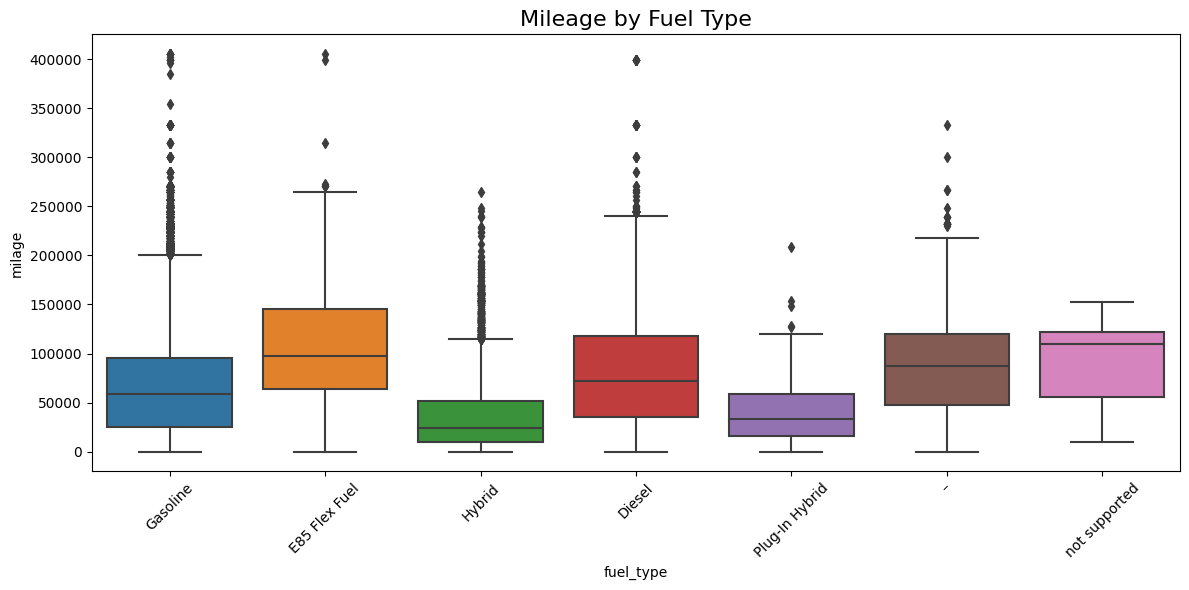

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='fuel_type', y='milage')
plt.title('Mileage by Fuel Type', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.6 Average Mileage by Brand

/tmp/ipykernel_17/769588392.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='brand', y='milage', estimator=np.mean, ci=None)


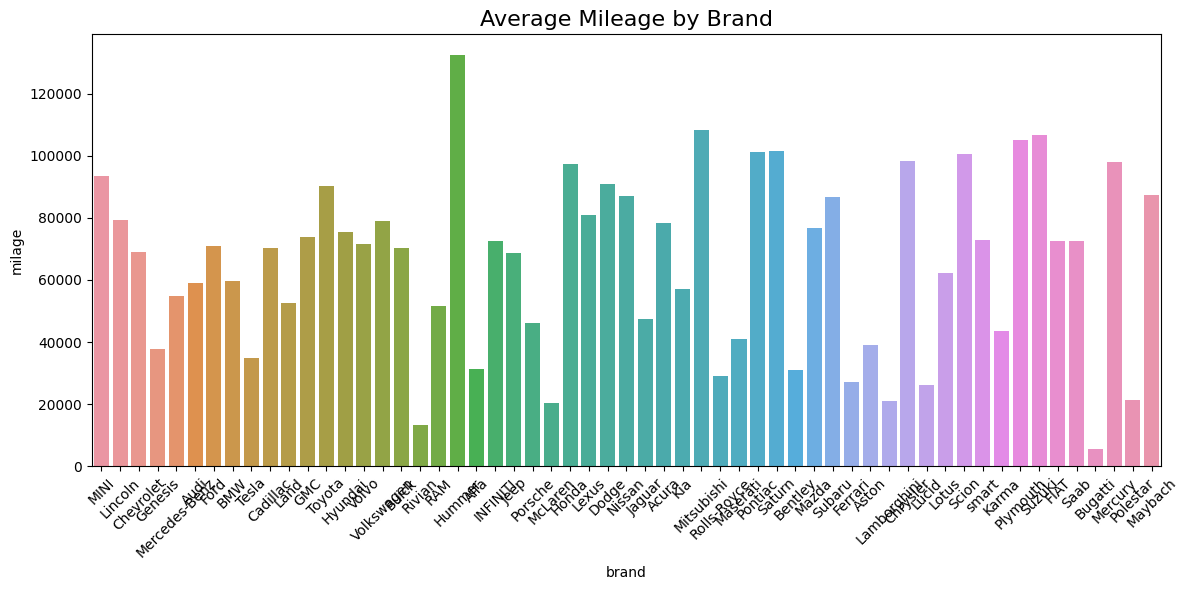

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='brand', y='milage', estimator=np.mean, ci=None)
plt.title('Average Mileage by Brand', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

## 2.1 Checking for distinct values for each feature

In [11]:
for i in df.columns:
    if df[i].nunique()<2:
        print(f'{i} has only one unique value. ')

clean_title has only one unique value. 


The 'Clean_' feature has only one unique value, so we can drop it.

In [12]:
df.drop(['id','clean_title'],axis=1,inplace=True)
df.shape

(188533, 11)

## 2.2 Handling missing values

In [13]:
df.isnull().sum().sum()

7535

In [14]:
df.dropna(inplace=True)

In [15]:
df.isnull().sum().sum()

0

There are no missing values, so we can proceed.

## 2.3 Converting categorical variables into numerical format using one-hot encoding

In [16]:
df = pd.get_dummies(df, columns=['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident','engine' ], drop_first=True)

# 3. Data Preparation

## 3.1 Defining X features and price as target variable

In [17]:
X = df.drop('price', axis=1)
y = df['price']

## 3.2 Splitting Data into training and test sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training and Evaluation

## 4.1 Xgboost Regressor

In [19]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,      
    max_depth=5,           
    learning_rate=0.1,     
    subsample=0.8,        
    random_state=42        
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'XGBoost Root Mean Squared Error: {rmse_xgb}')

XGBoost Root Mean Squared Error: 67003.09126576487


## 4.2 Random Forest

In [20]:
rf_model = RandomForestRegressor(
    n_estimators=100,     
    max_depth=10,         
    min_samples_split=2,
    min_samples_leaf=1,    
    random_state=42      
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest Root Mean Squared Error: {rmse_rf}')

Random Forest Root Mean Squared Error: 68418.85393408517


# 5. Final Predictions

In this scenario, XGBoost performs better compared to Random Forest. Therefore, our final submission will be based on the predictions of the XGBoost model.

## 5.1 Getting test data and Align with training features

In [21]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

test_ids=test_df['id']

test_df.drop(columns=['id','clean_title'], inplace=True)

test_df = pd.get_dummies(test_df, columns=['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident','engine'], drop_first=True)

missing_cols = set(X.columns) - set(test_df.columns)

missing_cols

missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[X.columns]

test_df.shape

(125690, 3583)

In [22]:
test_predictions=xgb_model.predict(test_df)

final_submission = pd.DataFrame({
    'id': test_ids,
    'price': test_predictions
})

# Save the blended predictions
final_submission.to_csv('Gxboost_predictions_submission.csv', index=False)

print("Submission Done")

Submission Done
